In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from rubin_sim.data import get_baseline
import rubin_sim.maf as maf
import sqlite3
import pandas as pd
import os

In [2]:
#baseline_file = get_baseline()
baseline_file = 'long_thrash_v3.1_0yrs.db'
run_name = os.path.basename(baseline_file.replace('.db', ''))

In [3]:
#sqls = {'note like "DD%%"': 'DDFs', 'note ="greedy"': 'greedy', 'note like "blob,%"': 'blobs',
#        'note like "blob_twi%"': 'blobs twilight', 'note="twilight_neo"': 'twilight NEO',
#       'note ="long"': 'long', 'note like "blob_long%"': 'long start', '': 'Everything'}

sqls = {'note ="long"': 'long', 'note like "blob_long%"': 'long start', '': 'Everything'}

In [4]:
bundle_list = []
ra_plots = [maf.plots.HealpixSkyMap()]
aa_plots = [maf.plots.LambertSkyMap()]
for sql in sqls:
    slicer = maf.HealpixSlicer()
    metric = maf.CountMetric(col='night', units='#', metric_name=sqls[sql])
    
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, plot_funcs=ra_plots))
    
    slicer = maf.HealpixSlicer(lat_col='altitude', lon_col='azimuth')
    metric = maf.CountMetric(col='night', units='#', metric_name=sqls[sql]+' alt/az')
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, plot_funcs=aa_plots))
    
    slicer = maf.UniSlicer()
    metric = maf.CountMetric(col="night")
    summary = [maf.PassMetric()]
    bundle_list.append(maf.MetricBundle(metric, slicer, sql, summary_metrics=summary))
    
    slicer = maf.HourglassSlicer()
    metric = maf.HourglassMetric()
    
    extra = ' and '
    if sql == '':
        extra = ''
    
    bundle = maf.MetricBundle(
            metric,
            slicer,
            sql + extra + ' night < 366',
        )
    bundle_list.append(bundle)
    
    

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


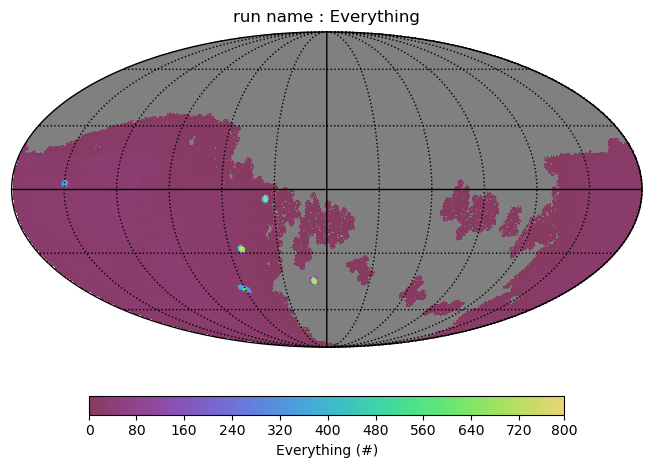

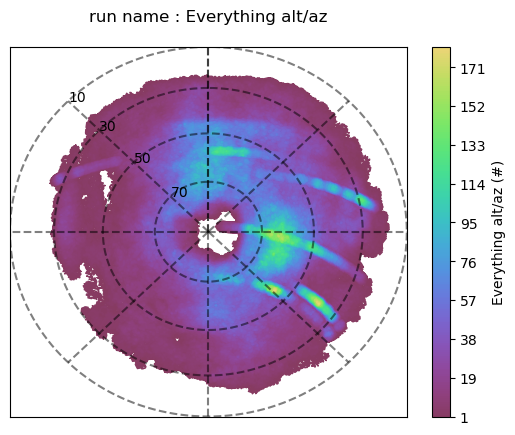

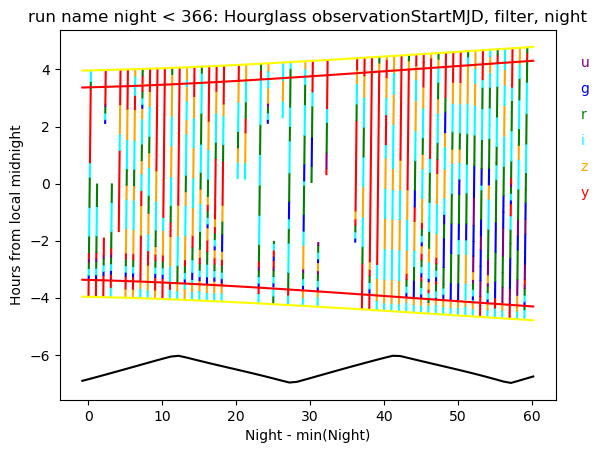

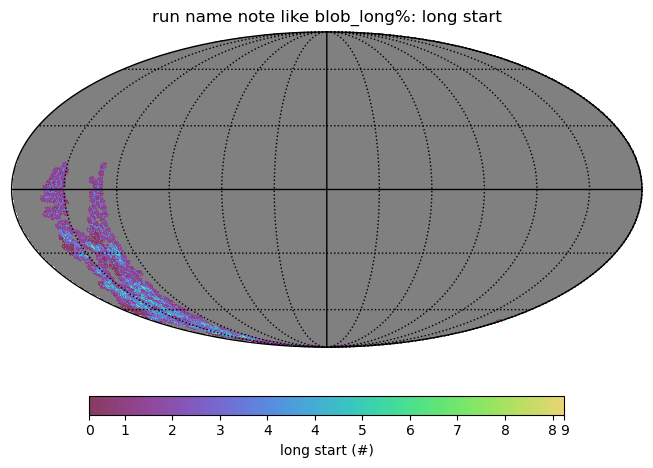

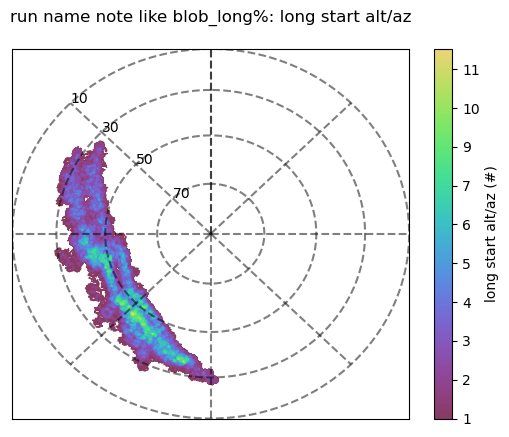

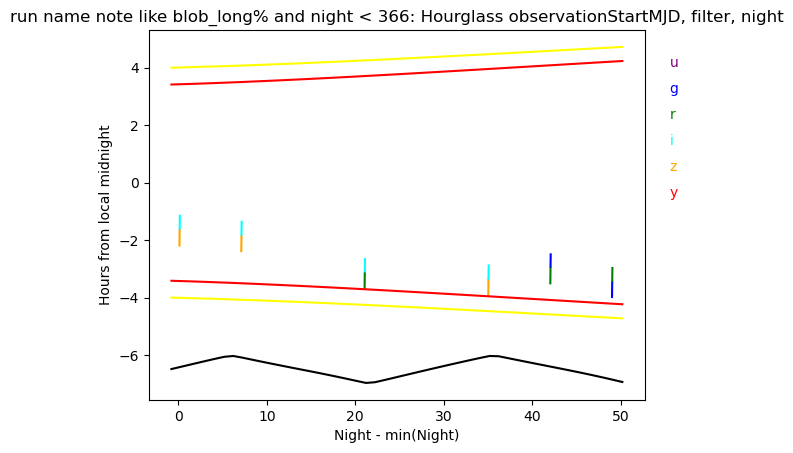

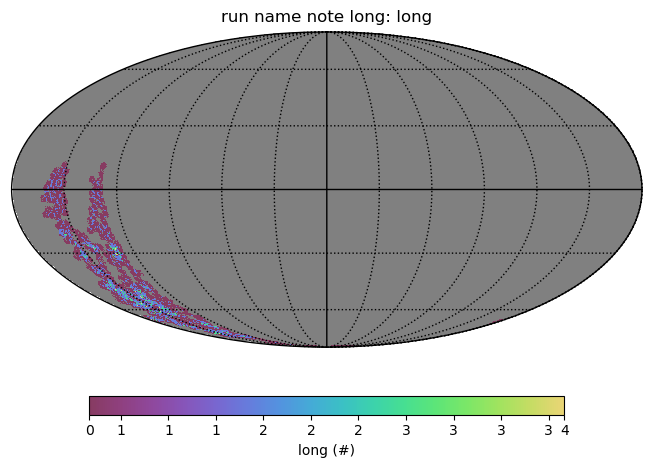

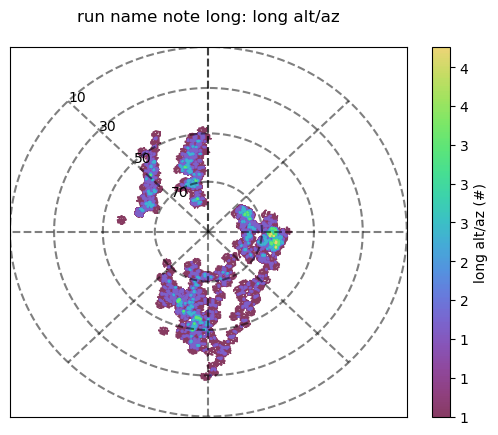

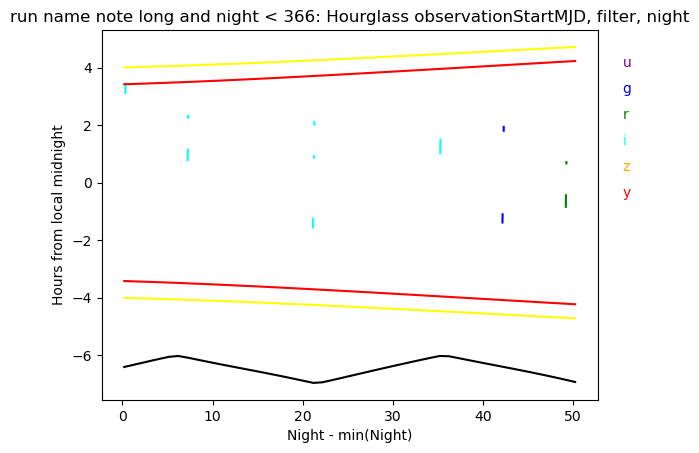

In [5]:
bd = maf.make_bundles_dict_from_list(bundle_list)
mbg = maf.MetricBundleGroup(bd, baseline_file, 'temp')
mbg.run_all()
mbg.plot_all(closefigs=False)

In [6]:
total = 0
for m in bundle_list:
    if len(m.summary_values) > 0:
        print(m.constraint, m.summary_values['Pass '][0][0],  m.summary_values['Pass '][0][0]/2086079.0)
        total += np.max(m.summary_values['Pass '][0][0])

note ="long" 237.0 0.00011361027075197056
note like "blob_long%" 548.0 0.00026269379059949314
 35601.0 0.017065988392577655


In [7]:
total/2

18193.0

In [8]:
# let's loop over and figure out how often each type executes

con = sqlite3.connect(baseline_file)
n_un = []

for sql in sqls:
    if sql == '':
        val = pd.read_sql('select count(distinct(night)) from observations  ;', con)
    else:
        val = pd.read_sql('select count(distinct(night)) from observations where ' + sql + ' ;', con)
    n_un.append(np.max(val))

In [9]:
n_un

[6, 6, 54]

In [10]:
sqls

{'note ="long"': 'long',
 'note like "blob_long%"': 'long start',
 '': 'Everything'}